In [1]:
!pip install pycocotools opencv-python numpy matplotlib pillow gtts

In [2]:
from pycocotools.coco import COCO
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import os

# Correct dataset path (use forward slashes `/` for Windows)
dataDir = "E:/PBL"
dataType = "val2017"  # Change to 'train2017' if needed

# Correct annotation file path
annFile = f"{dataDir}/annotations/instances_{dataType}.json"

# Check if the file exists
if os.path.exists(annFile):
    print("✅ Annotation file found:", annFile)
else:
    print("❌ Error: Annotation file not found! Check the path.")


✅ Annotation file found: E:/PBL/annotations/instances_val2017.json


In [4]:
coco = COCO(annFile)

# Display categories
cats = coco.loadCats(coco.getCatIds())
print("Categories:", [cat['name'] for cat in cats])


loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
Categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


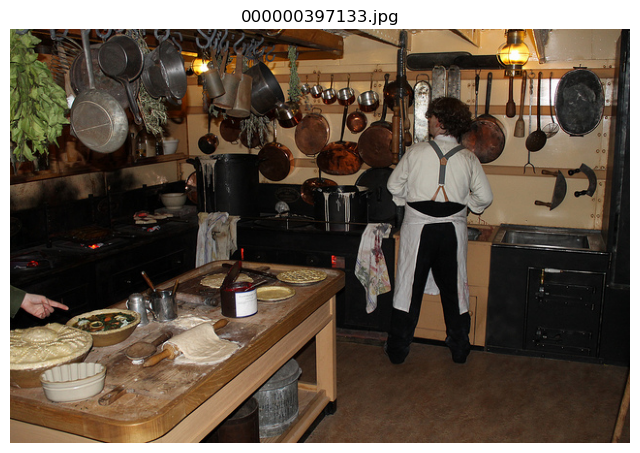

In [5]:
def load_coco_image(coco, img_id, data_dir, data_type):
    # Load image metadata
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, data_type, img_info["file_name"])

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_info["file_name"])
    plt.show()
    return img_info

# Select a random image
img_ids = coco.getImgIds()
selected_img_id = img_ids[0]  # Choose the first image
img_info = load_coco_image(coco, selected_img_id, dataDir, dataType)


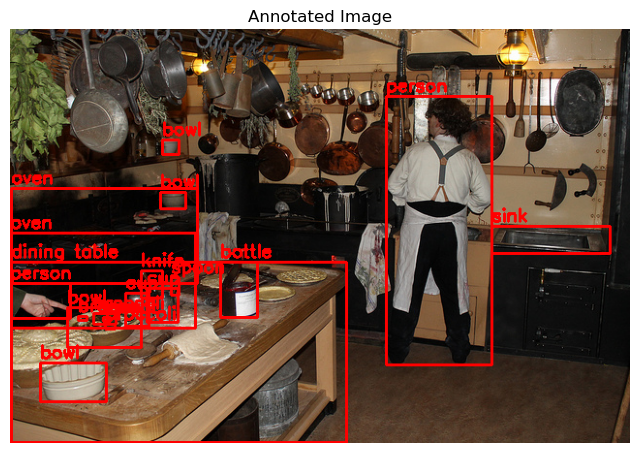

In [6]:
def draw_bounding_boxes(coco, img_id, img_path):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        bbox = ann["bbox"]  # [x, y, width, height]
        category_id = ann["category_id"]
        category_name = coco.loadCats([category_id])[0]["name"]

        x, y, w, h = map(int, bbox)
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(img, category_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Display image with bounding boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Annotated Image")
    plt.show()

# Draw bounding boxes
draw_bounding_boxes(coco, selected_img_id, os.path.join(dataDir, dataType, img_info["file_name"]))


In [7]:
# !pip install torch torchvision numpy opencv-python ultralytics


In [8]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

# Load the pre-trained YOLOv5 model
model = YOLO("yolov5su.pt")  # Updated model with better performance

# Define image path correctly
image_path = "E:/PBL/val2017/000000017207.jpg"  # Fix the path format

# Load image
image = Image.open(image_path)

# Perform object detection
results = model(image)

# Show results correctly (iterate over the list)
for result in results:
    result.show()  # Show image with detections



0: 480x640 1 person, 1 car, 1 motorcycle, 1 bus, 1 truck, 1479.0ms
Speed: 168.2ms preprocess, 1479.0ms inference, 315.8ms postprocess per image at shape (1, 3, 480, 640)


In [9]:
# Save output images
output_dir = "E:/PBL/detections/"  # Folder where detections will be saved
import os

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through the results list
for i, result in enumerate(results):
    output_path = f"{output_dir}/detected_{i}.jpg"
    result.save(output_path)  # Save the image
    print(f"✅ Detected image saved at {output_path}")


✅ Detected image saved at E:/PBL/detections//detected_0.jpg


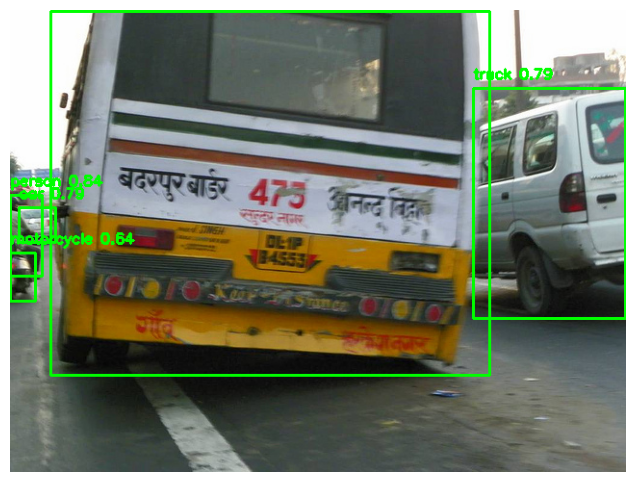

In [10]:
# Convert image to OpenCV format
img = np.array(image)

# Draw bounding boxes
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = f"{model.names[int(box.cls[0])]} {box.conf[0]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with detections
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.show()


In [11]:
# !pip install torch torchvision opencv-python matplotlib timm

In [12]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load MiDaS model (pre-trained for depth estimation)
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")

# Set model to evaluation mode
midas.eval()

# Define image path (same image used in YOLO)
image_path = "E:/PBL/val2017/000000017207.jpg"
image = Image.open(image_path)


Using cache found in C:\Users\Asus/.cache\torch\hub\intel-isl_MiDaS_master
F:\Games\anaconda\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in C:\Users\Asus/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [13]:
# Transform image for MiDaS
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize to model input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize
])

# Convert image to model format
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension


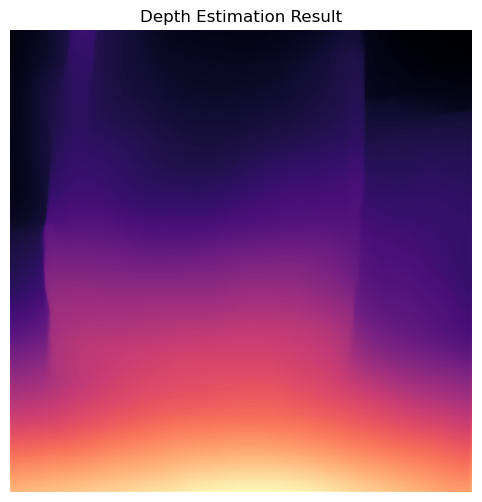

In [14]:
# Perform depth estimation
with torch.no_grad():
    depth_map = midas(input_tensor)

# Convert depth map to numpy array
depth_map = depth_map.squeeze().numpy()

# Normalize depth map for visualization
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Display depth map
plt.figure(figsize=(8, 6))
plt.imshow(depth_map, cmap="magma")  # 'magma' gives good contrast
plt.axis("off")
plt.title("Depth Estimation Result")
plt.show()

In [15]:
# Set depth threshold (adjust based on camera calibration)
threshold = 0.3  # Lower values indicate closer objects

# Check if any object is too close
if (depth_map < threshold).any():
    print("⚠️ Warning: Obstacle detected nearby!")
else:
    print("✅ Safe: No obstacles detected.")

⚠️ Warning: Obstacle detected nearby!


In [16]:
pip install opencv-python torch torchvision ultralytics

Note: you may need to restart the kernel to use updated packages.


In [17]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image

# Load YOLO model
model = YOLO("yolov5su.pt")  # Use 'yolov5s.pt' if needed

# Load MiDaS model for depth estimation
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval()

# Transformation for MiDaS
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Open webcam (0 = default camera, use 1 for external webcam)
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()  # Capture frame from webcam
    if not ret:
        break  # Stop if no frame is captured

    # Convert frame (NumPy array) to PIL Image
    image_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Perform YOLO object detection
    results = model(image_pil)

    # Draw YOLO detections on frame
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = f"{model.names[int(box.cls)]} {box.conf[0]:.2f}"
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert frame for MiDaS depth estimation
    image_tensor = transform(image_pil).unsqueeze(0)

    with torch.no_grad():
        depth_map = midas(image_tensor).squeeze().numpy()

    # Normalize depth map
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    # Set obstacle warning threshold
    threshold = 0.3

    if (depth_map < threshold).any():
        warning_text = "⚠️ Obstacle Detected!"
        color = (0, 0, 255)  # Red
    else:
        warning_text = "✅ Safe"
        color = (0, 255, 0)  # Green

    # Display warning on frame
    cv2.putText(frame, warning_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Show output
    cv2.imshow("Object Detection & Depth Estimation", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

Using cache found in C:\Users\Asus/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Asus/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Loading weights:  None

0: 480x640 (no detections), 190.1ms
Speed: 4.5ms preprocess, 190.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 337.3ms
Speed: 10.0ms preprocess, 337.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 199.6ms
Speed: 16.0ms preprocess, 199.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 181.6ms
Speed: 3.0ms preprocess, 181.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 195.1ms
Speed: 2.0ms preprocess, 195.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


In [18]:
# pip install pyttsx3

In [19]:
import cv2
import torch
import numpy as np
import pyttsx3
import threading
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image

# Initialize pyttsx3 for text-to-speech
engine = pyttsx3.init()

# Load YOLO model
model = YOLO("yolov5su.pt")  # Use 'yolov5s.pt' if needed

# Load MiDaS model for depth estimation
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval()

# Transformation for MiDaS
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Open webcam (0 = default camera, use 1 for external webcam)
cap = cv2.VideoCapture(0)

def speak(text):
    """Function to speak the text in a non-blocking way"""
    engine.say(text)
    engine.runAndWait()

while cap.isOpened():
    ret, frame = cap.read()  # Capture frame from webcam
    if not ret:
        break  # Stop if no frame is captured

    # Convert frame (NumPy array) to PIL Image
    image_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Perform YOLO object detection
    results = model(image_pil)

    # Draw YOLO detections on frame and announce objects
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = f"{model.names[int(box.cls)]} {box.conf[0]:.2f}"
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Announce recognized object in a separate thread
            threading.Thread(target=speak, args=(f"I see a {model.names[int(box.cls)]}",)).start()

    # Convert frame for MiDaS depth estimation
    image_tensor = transform(image_pil).unsqueeze(0)

    with torch.no_grad():
        depth_map = midas(image_tensor).squeeze().numpy()

    # Normalize depth map
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    # Set obstacle warning threshold
    threshold = 0.3

    if (depth_map < threshold).any():
        warning_text = "⚠️ Obstacle Detected!"
        color = (0, 0, 255)  # Red
        threading.Thread(target=speak, args=("Warning! Obstacle detected in your path.",)).start()
    else:
        warning_text = "✅ Safe"
        color = (0, 255, 0)  # Green

    # Display warning on frame
    cv2.putText(frame, warning_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Show output
    cv2.imshow("Object Detection & Depth Estimation", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


Using cache found in C:\Users\Asus/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Asus/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Loading weights:  None

0: 480x640 2 persons, 203.6ms
Speed: 3.0ms preprocess, 203.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Exception in thread Thread-13 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\1047250096.py", line 33, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started
Exception in thread Thread-14 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\1047250096.py", line 33, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    

In [ ]:
import cv2
import torch
import numpy as np
import pyttsx3
import threading
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import winsound  # Used for the sound warning

# Initialize pyttsx3 for text-to-speech
engine = pyttsx3.init()

# Load YOLO model
model = YOLO("yolov5su.pt")  # Use 'yolov5s.pt' if needed

# Load MiDaS model for depth estimation
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval()

# Transformation for MiDaS
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Open webcam (0 = default camera, use 1 for external webcam)
cap = cv2.VideoCapture(0)

# Flag for obstacle detection
obstacle_detected = False

def speak(text):
    """Function to speak the text in a non-blocking way"""
    engine.say(text)
    engine.runAndWait()

def play_warning_sound():
    """Function to play warning sound"""
    winsound.Beep(1000, 500)  # Frequency of 1000 Hz, duration 500ms

while cap.isOpened():
    ret, frame = cap.read()  # Capture frame from webcam
    if not ret:
        break  # Stop if no frame is captured

    # Convert frame (NumPy array) to PIL Image
    image_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Perform YOLO object detection
    results = model(image_pil)

    # Draw YOLO detections on frame and announce objects
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = f"{model.names[int(box.cls)]} {box.conf[0]:.2f}"
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Announce recognized object in a separate thread
            threading.Thread(target=speak, args=(f"I see a {model.names[int(box.cls)]}",)).start()

    # Convert frame for MiDaS depth estimation
    image_tensor = transform(image_pil).unsqueeze(0)

    with torch.no_grad():
        depth_map = midas(image_tensor).squeeze().numpy()

    # Normalize depth map
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    # Set obstacle warning threshold
    threshold = 0.3  # Below this depth, consider it as an obstacle

    if (depth_map < threshold).any():  # If there's any area with depth less than threshold
        if not obstacle_detected:
            # If obstacle was not previously detected, trigger sound and speech
            warning_text = "⚠️ Obstacle Detected!"
            color = (0, 0, 255)  # Red
            threading.Thread(target=speak, args=("Warning! Obstacle detected in your path.",)).start()
            threading.Thread(target=play_warning_sound).start()  # Play sound in background
            obstacle_detected = True  # Set flag to prevent continuous beeping
    else:
        warning_text = "✅ Safe"
        color = (0, 255, 0)  # Green
        obstacle_detected = False  # Reset the flag if no obstacle is detected

    # Display warning on frame
    cv2.putText(frame, warning_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Show output
    cv2.imshow("Object Detection & Depth Estimation", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


Using cache found in C:\Users\Asus/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Asus/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Loading weights:  None

0: 480x640 2 persons, 294.9ms
Speed: 3.0ms preprocess, 294.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Exception in thread Thread-15 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
Exception in thread Thread-16 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    


0: 480x640 2 persons, 271.4ms
Speed: 4.0ms preprocess, 271.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Exception in thread Thread-20 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started



0: 480x640 2 persons, 248.1ms
Speed: 3.0ms preprocess, 248.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Exception in thread Thread-21 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
Exception in thread Thread-22 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    


0: 480x640 2 persons, 263.9ms
Speed: 2.5ms preprocess, 263.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Exception in thread Thread-23 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started
Exception in thread Thread-24 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    


0: 480x640 3 persons, 248.0ms
Speed: 2.0ms preprocess, 248.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Exception in thread Thread-26 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
Exception in thread Thread-27 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    


0: 480x640 2 persons, 193.3ms
Speed: 2.0ms preprocess, 193.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Exception in thread Thread-28 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
Exception in thread Thread-29 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    


0: 480x640 2 persons, 246.9ms
Speed: 3.0ms preprocess, 246.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Exception in thread Thread-30 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
Exception in thread Thread-31 (speak):
Traceback (most recent call last):
  File "F:\Games\anaconda\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self.run()
  File "F:\Games\anaconda\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_14596\3647059516.py", line 37, in speak
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    raise RuntimeError('run loop already started')
RuntimeError: run loop already started
  File "F:\Games\anaconda\Lib\site-packages\pyttsx3\engine.py", line 180, in runAndWait
    